<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/colab/Ternary_Phase_Diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ternary Phase Diagramの計算

Sep. 2019

作成したPTフラッシュ計算コードを用いて，ある温度圧力でのTernary Phase Diagramを書いて見たいと思います。

**TODO**

*   Refactoring
*   プロットの修正


**ライブラリのインポート**

複数の成分毎にフラッシュ計算を行うので、進捗がわかりやすいようにtqdmもインポートします。

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Ternary diagramプロット用には、python-ternaryを使ってみることにします。

In [2]:
!pip install python-ternary
import ternary

  Created wheel for python-ternary: filename=python_ternary-1.0.6-cp36-none-any.whl size=16955 sha256=0ce814e1c8716f7436d2fec59ad00acb0691eb1f82f651fc40875c705dab030d
  Stored in directory: /root/.cache/pip/wheels/39/05/11/9662bb9f74c86df1080325eb5ade3033d92d07fad644fc3e1e
Successfully built python-ternary


用意したPTフラッシュ計算コードを、wgetして、クラスをインポートします。

In [3]:
!rm mixture.py
!wget https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/mixture.py

from mixture import Components, Mixture

rm: cannot remove 'mixture.py': No such file or directory
--2019-10-23 13:59:37--  https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/mixture.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7320 (7.1K) [text/plain]
Saving to: ‘mixture.py’

mixture.py          100%[===================>]   7.15K  --.-KB/s    in 0s      

2019-10-23 13:59:38 (107 MB/s) - ‘mixture.py’ saved [7320/7320]



## 成分の設定

Mixtureを構成する成分を設定

In [0]:
# Set components which you need.
methane = Components(name='methane', Pc=46.00155, Tc=190.6, omega=0.008)
butane = Components(name='butane', Pc=37.996875, Tc=425.2, omega=0.193)
decane = Components(name='decane', Pc=21.0756, Tc=617.6, omega=0.49)
co2 = Components(name='co2', Pc=73.7646, Tc=304.2, omega=0.225)

feed = [co2, butane, decane]

kik = np.array([[0     , 0.1333, 0.1141],
                [0.1333, 0     , 0     ],
                [0.1141, 0     , 0     ]
                ])

各成分のモル比を設定し、リストに格納。

In [0]:
Z1, step = np.linspace(0, 1, 40, endpoint=True, retstep=True)

Zi_list = []

for z1 in Z1:
    Z2 = np.linspace(0, 1-z1, int(1+round((1-z1)/step)), endpoint=True)
    for z2 in Z2:
        z3 = 1 - z1 - z2
        Zi_list.append([z1,z2,z3])

Zi_list = np.array(Zi_list)
# Zi_list

## PTフラッシュ計算

各Mixtureに対して、PTフラッシュを実施し、リストに格納。

In [6]:
# Pressure
P = 1250/14.5038 # 1250psia

# Temperature
T = (160-32)*5/9+273.15 # 160degF


# PT Flash Calculation
ml = [] # mixture list

for Zi in tqdm(Zi_list):
    m = Mixture(feed, Zi)
    m.set_BIPs(kik)
    m.PT_flash(P,T)
    ml.append(m)

## Ternary Phase Diagramの作成

V値をもとに、Ternary phase diagramの作成

In [0]:
x, y, z = np.array([]), np.array([]), np.array([])
lx, ly, lz = np.array([]), np.array([]), np.array([])
vx, vy, vz = np.array([]), np.array([]), np.array([])

for m in ml:
    if m.phase == 'two-phase':
        x = np.append(x, m.Zi[1])
        y = np.append(y, m.Zi[0])
        z = np.append(z, m.Zi[2])
        lx = np.append(lx, m.Xi[1])
        ly = np.append(ly, m.Xi[0])
        lz = np.append(lz, m.Xi[2])
        vx = np.append(vx, m.Yi[1])
        vy = np.append(vy, m.Yi[0])
        vz = np.append(vz, m.Yi[2])

# (right corner, top corner, left corner) for ternary plot
v = [(x,y,z) for (x,y,z) in zip(vx,vy,vz)]
l = [(x,y,z) for (x,y,z) in zip(lx,ly,lz)]

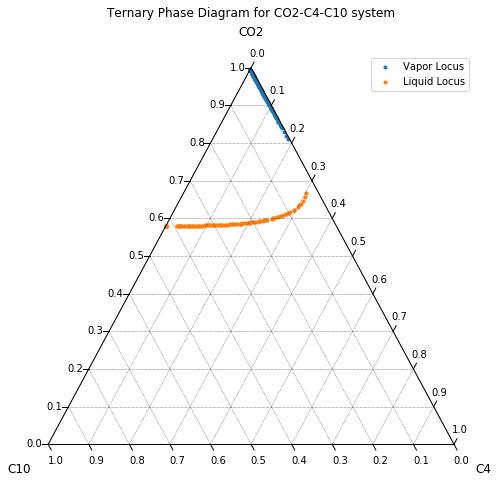

In [8]:
## Boundary and Gridlines
figure, tax = ternary.figure(scale=1)
figure.set_size_inches(8, 8)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=0.1)

# Set Axis labels and Title
fontsize = 12
tax.set_title("Ternary Phase Diagram for CO2-C4-C10 system\n\n", fontsize=fontsize)
tax.right_corner_label("C4", fontsize=fontsize)
tax.top_corner_label("CO2", fontsize=fontsize)
tax.left_corner_label("C10", fontsize=fontsize)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, offset=0.015, tick_formats="%.1f", clockwise=True)

# Plot the data
tax.scatter(v, marker='.', label='Vapor Locus')
tax.scatter(l, marker='.', label='Liquid Locus')
tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

ternary.plt.show()

*End of notebook...*